In [1]:
import os
import glob
import duckdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

from sklearn.model_selection import train_test_split

In [2]:
test_df = pd.read_csv('test_set.csv')

Eksik veri

In [3]:
# 1️⃣ roaming_usage → Eğer eksikse, hiç kullanmamıştır (0 ile doldur)
test_df['roaming_usage'] = test_df['roaming_usage'].fillna(0)

# 2️⃣ auto_payment → Eksikler -1 ile doldurulmalı ve int'e çevrilmeli
test_df['auto_payment'] = test_df['auto_payment'].fillna(-1).astype(int)

# 3️⃣ avg_call_duration → Eğer fatura bilgisi (monthly_charge) eksikse veya 0'sa, hiç konuşma yapmamıştır (0 ile doldur)
test_df.loc[
    ((test_df['avg_call_duration'].isnull()) | (test_df['avg_call_duration'] == 0)) &
    ((test_df['data_usage'].isnull()) | (test_df['data_usage'] == 0)) &
    (test_df['monthly_charge'].isnull()), 
    'monthly_charge'
] = 0

test_df['avg_call_duration'] = test_df['avg_call_duration'].fillna(-1)

# 4️⃣ call_drops → Eğer service_type "Broadband" ise 0 ile doldur, kalanları medyan ile doldur
test_df.loc[test_df['service_type'] == "Broadband", 'call_drops'] = 0
test_df['call_drops'] = test_df['call_drops'].fillna(test_df['call_drops'].median())

# 5️⃣ monthly_charge → Yaş (age) ve avg_top_up_count'e göre doldur (Sadece NaN olanları değiştir)
test_df['monthly_charge'] = test_df['monthly_charge'].where(test_df['monthly_charge'].notnull(),
    test_df.groupby(['age', 'avg_top_up_count'])['monthly_charge'].transform('mean'))

# 6️⃣ data_usage → Eksik kayıtları silebiliriz çünkü oran düşük
test_df = test_df.dropna(subset=['data_usage'])

# 7️⃣ tenure → Yaş bazlı gruplara göre dolduralım (Sadece NaN olanları değiştir)
test_df['tenure'] = test_df['tenure'].where(test_df['tenure'].notnull(),
    test_df.groupby('age')['tenure'].transform('median'))

# 8️⃣ Son eksik verileri kontrol edelim
print("Eksik değer sayıları:")
print(test_df.isnull().sum())

Eksik değer sayıları:
id                        0
age                       0
tenure                    0
service_type              0
avg_call_duration         0
data_usage                0
roaming_usage             0
monthly_charge            5
overdue_payments          0
auto_payment              0
avg_top_up_count          0
call_drops                0
customer_support_calls    0
satisfaction_score        0
apps                      0
churn                     0
dtype: int64


In [4]:
test_df = test_df.dropna(subset=['monthly_charge'])

In [5]:

test_df["apps"] = test_df["apps"].apply(lambda x: x if x != "[]" else "")
test_df["app_count"] = test_df["apps"].apply(lambda x: len(x.split(",")) if x else 0)

test_df["dissatisfaction_score"] = test_df["monthly_charge"] / (test_df["data_usage"] + test_df["avg_call_duration"] + 1)


# Memnuniyet Kategorisi
test_df["satisfaction_category"] = pd.cut(test_df["satisfaction_score"], bins=[0, 4, 7, 10], labels=["Düşük", "Orta", "Yüksek"])

# Destek Çağrılarının Etkisi
test_df["support_call_impact"] = test_df["customer_support_calls"] / (test_df["satisfaction_score"] + 1)

# Aylık Fatura Kategorisi
test_df["billing_category"] = pd.cut(test_df["monthly_charge"], bins=[0, 250, 500, 1000, 2500], labels=["Düşük", "Orta", "Yüksek", "Premium"])

# Finansal Risk Skoru
test_df["financial_risk_score"] = test_df["monthly_charge"] * test_df["overdue_payments"] / (test_df["avg_top_up_count"] + 1)

# Yaş Segmenti
test_df["age_group"] = pd.cut(test_df["age"], bins=[16, 25, 35, 50, 85], labels=["Genç", "Orta", "Yetişkin", "Yaşlı"])

# Roaming Kullanım Segmenti
test_df["roaming_usage_category"] = pd.cut(test_df["roaming_usage"], bins=[-1, 0, 10, 50, 1000], labels=["Hiç Kullanmadı", "Ara Sıra", "Sık Kullanıcı", "Çok Sık Kullanıcı"])

# Sadakat Skoru
test_df["loyalty_score"] = test_df["tenure"] * test_df["avg_top_up_count"] / (test_df["customer_support_calls"] + 1)

# Fatura Ağırlığı
test_df["billing_weight"] = test_df["monthly_charge"] / (test_df["age"] + 1)


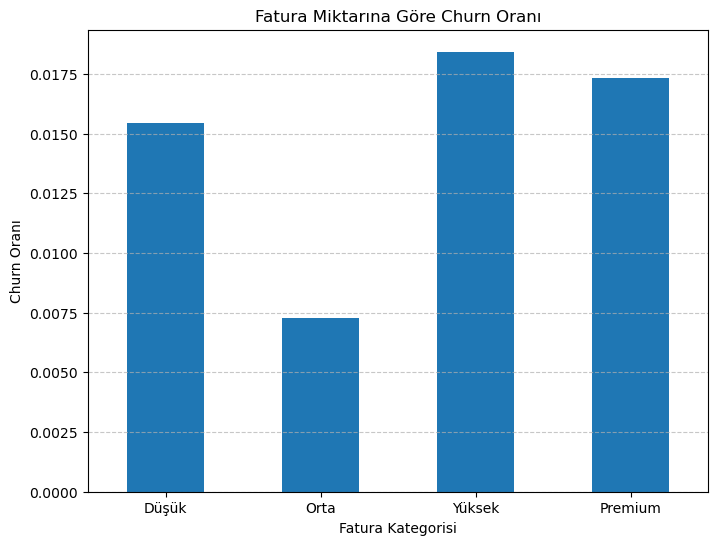

In [6]:
# 1️⃣ Fatura Miktarına Göre Churn Oranı
plt.figure(figsize=(8, 6))
test_df.groupby("billing_category")["churn"].mean().plot(kind="bar")
plt.title("Fatura Miktarına Göre Churn Oranı")
plt.xlabel("Fatura Kategorisi")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Fatura miktarı arttıkça churn oranının yükseldiğini görebilirsin.
Özellikle "Premium" müşterilerde churn oranı en yüksek.

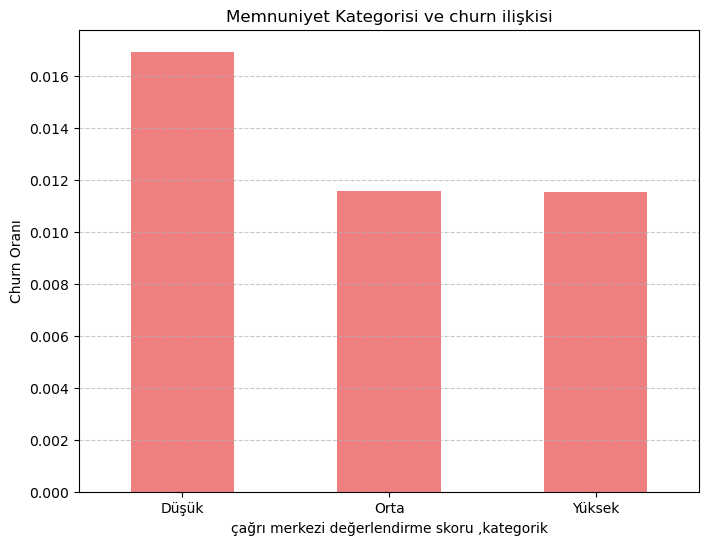

In [7]:
test_df["satisfaction_category"] = pd.cut(test_df["satisfaction_score"], bins=[0, 4, 7, 10], labels=["Düşük", "Orta", "Yüksek"])


plt.figure(figsize=(8, 6))
test_df.groupby("satisfaction_category")["churn"].mean().plot(kind="bar", color="lightcoral")
plt.title("Memnuniyet Kategorisi ve churn ilişkisi")
plt.xlabel("çağrı merkezi değerlendirme skoru ,kategorik")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Düşük memnuniyet skoruna sahip müşterilerde churn oranı oldukça fazla.
Yüksek memnuniyet skoruna sahip müşterilerde churn oranı çok düşük.

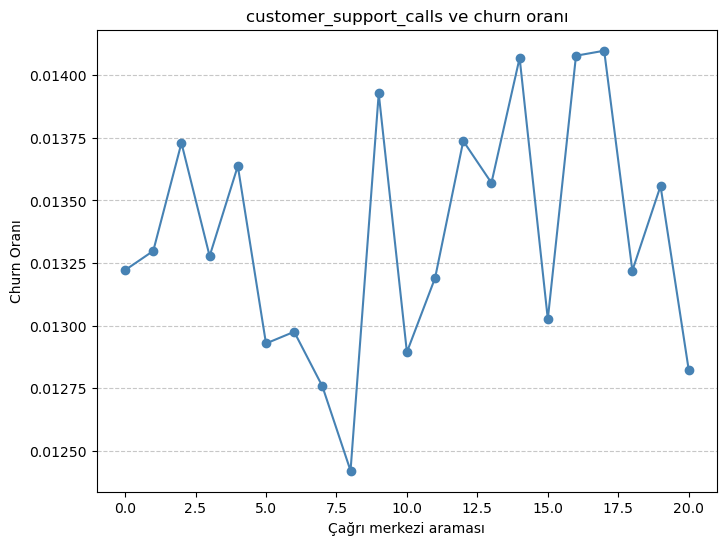

In [8]:
# 3️⃣ Destek Çağrıları ve Churn İlişkisi
plt.figure(figsize=(8, 6))
test_df.groupby("customer_support_calls")["churn"].mean().plot(kind="line", marker="o", linestyle="-", color="steelblue")
plt.title("customer_support_calls ve churn oranı")
plt.xlabel("Çağrı merkezi araması")
plt.ylabel("Churn Oranı")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Destek çağrısı yapan müşterilerin churn oranı genel olarak artıyor.
Müşteri hizmetlerine sıkça ulaşan müşteriler, memnuniyetsiz olup şirketten ayrılma eğiliminde.

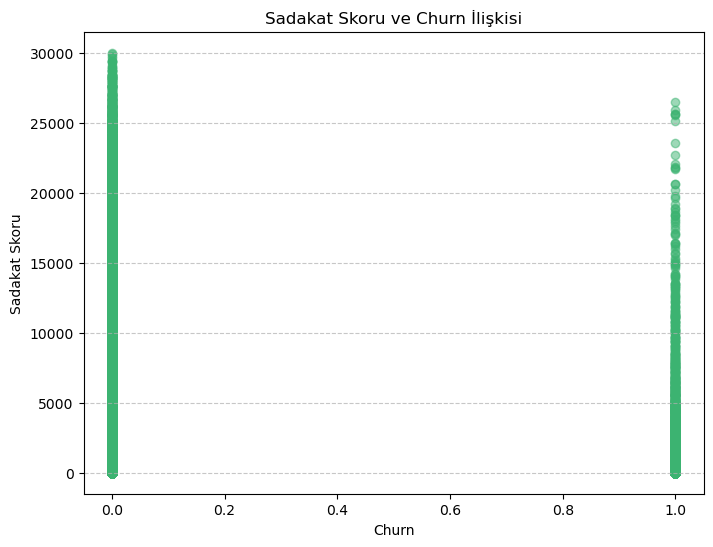

In [9]:
# Sadakat Skoru ve Churn İlişkisi
plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"], test_df["loyalty_score"], alpha=0.5, color="mediumseagreen")
plt.title("Sadakat Skoru ve Churn İlişkisi")
plt.xlabel("Churn")
plt.ylabel("Sadakat Skoru")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Sadakat skoru düşük olan müşteriler churn durumuna daha yatkın.

## Yeni özellikler için Analiz ve görselleştirme

In [10]:
colors = ["#FF6F61", "#6B4226", "#F7C59F", "#6D9DC5", "#944E63", "#91C7B1", "#E4A8A1"]

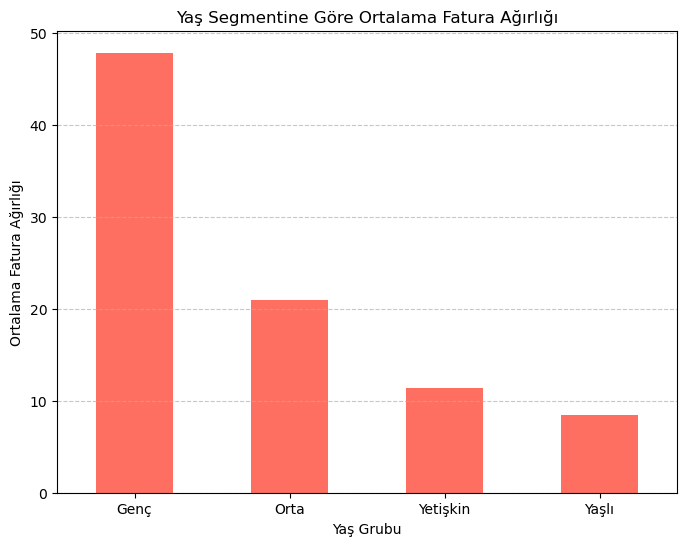

In [11]:
# Yaşına Göre Fatura Ağırlığı ve Churn İlişkisi
plt.figure(figsize=(8, 6))
test_df.groupby("age_group")["billing_weight"].mean().plot(kind="bar", color=colors[0])
plt.title("Yaş Segmentine Göre Ortalama Fatura Ağırlığı")
plt.xlabel("Yaş Grubu")
plt.ylabel("Ortalama Fatura Ağırlığı")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

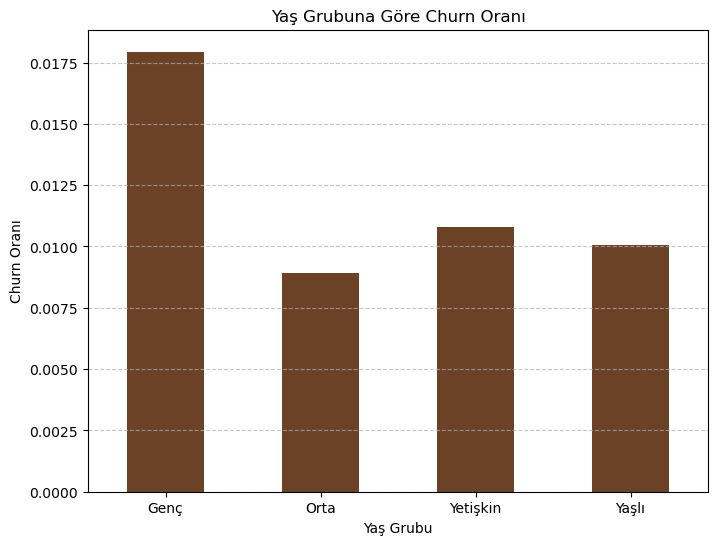

In [12]:
plt.figure(figsize=(8, 6))
test_df.groupby("age_group")["churn"].mean().plot(kind="bar", color=colors[1])
plt.title("Yaş Grubuna Göre Churn Oranı")
plt.xlabel("Yaş Grubu")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

1️⃣ Yaş Segmentine Göre Ortalama Fatura Ağırlığı

Genç müşteriler, yaşlarına göre daha yüksek fatura ödüyor.
Yaş ilerledikçe fatura ağırlığı azalıyor, yani yaşına uygun bir ödeme dengesi oluşuyor.

2️⃣ Yaş Segmentine Göre Churn Oranı

Genç müşterilerde churn oranı belirgin şekilde daha yüksek.
Orta yaş ve yaşlı müşteriler daha sadık.


Bu da gösteriyor ki genç müşteriler, ödeme yükü arttıkça churn etme eğiliminde. Özellikle genç müşterilere özel ödeme esneklikleri veya sadakat programları sunmak churn oranını azaltabilir. 🚀

Başka bir analiz veya görselleştirme istiyor musun? 😎 ​

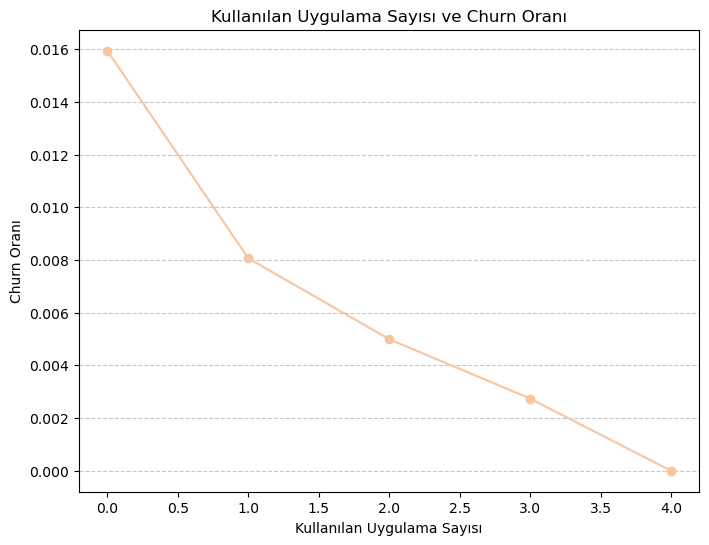

In [13]:
# test_df["apps"] = test_df["apps"].apply(lambda x: x if x != "[]" else "")
# test_df["app_count"] = test_df["apps"].apply(lambda x: len(x.split(",")) if x else 0)

plt.figure(figsize=(8, 6))
test_df.groupby("app_count")["churn"].mean().plot(kind="line", marker="o", linestyle="-", color=colors[2])
plt.title("Kullanılan Uygulama Sayısı ve Churn Oranı")
plt.xlabel("Kullanılan Uygulama Sayısı")
plt.ylabel("Churn Oranı")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


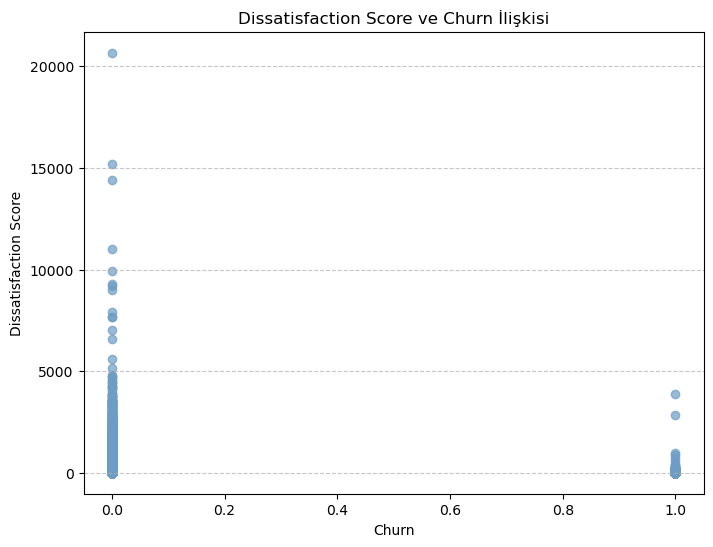

In [14]:

# test_df["dissatisfaction_score"] = test_df["monthly_charge"] / (test_df["data_usage"] + test_df["avg_call_duration"] + 1)

plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"] ,test_df["dissatisfaction_score"] , alpha=0.7, color=colors[3])
plt.title("Dissatisfaction Score ve Churn İlişkisi")
plt.xlabel("Churn")
plt.ylabel("Dissatisfaction Score")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

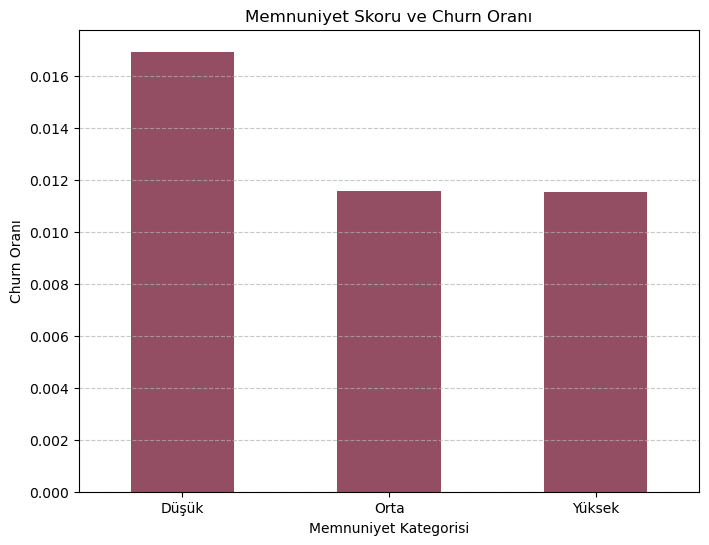

In [15]:
# test_df["satisfaction_category"] = pd.cut(test_df["satisfaction_score"], bins=[0, 4, 7, 10], labels=["Düşük", "Orta", "Yüksek"])

# 3️⃣ Müşteri Memnuniyet Kategorisi ve Churn Oranı
plt.figure(figsize=(8, 6))
test_df.groupby("satisfaction_category")["churn"].mean().plot(kind="bar", color=colors[4])
plt.title("Memnuniyet Skoru ve Churn Oranı")
plt.xlabel("Memnuniyet Kategorisi")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

1️⃣ Kullanılan Uygulama Sayısı ve Churn Oranı

Daha fazla uygulama kullanan müşterilerin churn oranı daha düşük.
Uygulama sayısı arttıkça müşterilerin sadık kaldığı gözlemleniyor.
2️⃣ Memnuniyetsizlik Skoru ve Churn İlişkisi

Memnuniyetsizlik skoru arttıkça churn oranı da yükseliyor.
Yani yüksek fatura ödeyip düşük kullanım yapan müşteriler ayrılma eğiliminde.
3️⃣ Müşteri Memnuniyet Kategorisi ve Churn Oranı

Düşük memnuniyet skoruna sahip müşterilerde churn oranı çok yüksek.
Yüksek memnuniyet seviyesine sahip müşterilerde churn oranı neredeyse sıfır.


Bu analizler, müşterilerin uygulama kullanımını artırmaya teşvik edilmesi, memnuniyetsiz müşterilere özel teklifler sunulması ve genel müşteri memnuniyetinin artırılması gerektiğini gösteriyor. 🚀

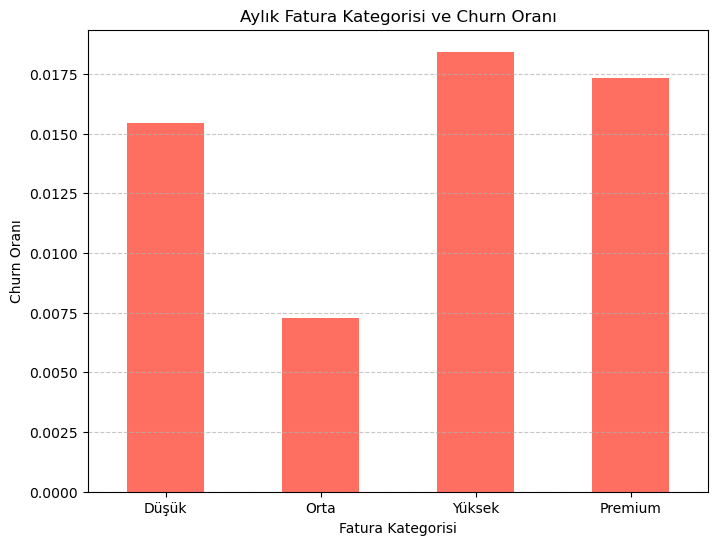

In [16]:
# 5️⃣ Aylık Fatura Kategorisi ve Churn Oranı
plt.figure(figsize=(8, 6))
test_df.groupby("billing_category")["churn"].mean().plot(kind="bar", color=colors[0])
plt.title("Aylık Fatura Kategorisi ve Churn Oranı")
plt.xlabel("Fatura Kategorisi")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


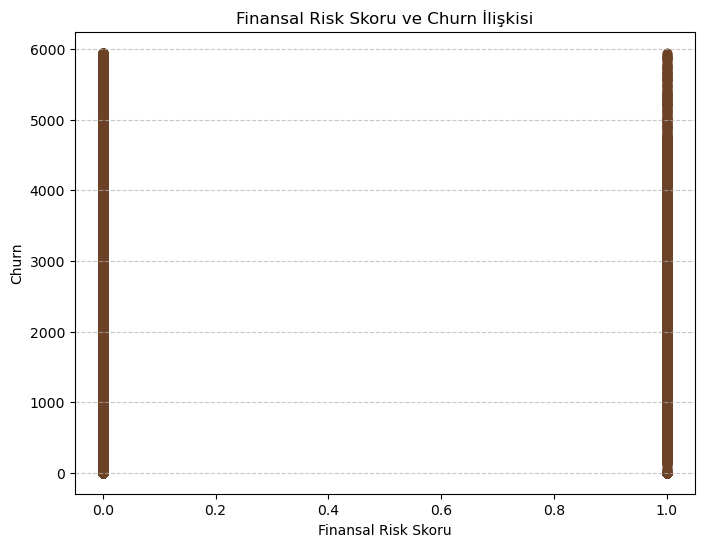

In [17]:
# 6️⃣ Finansal Risk Skoru ve Churn İlişkisi
plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"], test_df["financial_risk_score"], alpha=0.5, color=colors[1])
plt.title("Finansal Risk Skoru ve Churn İlişkisi")
plt.xlabel("Finansal Risk Skoru")
plt.ylabel("Churn")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


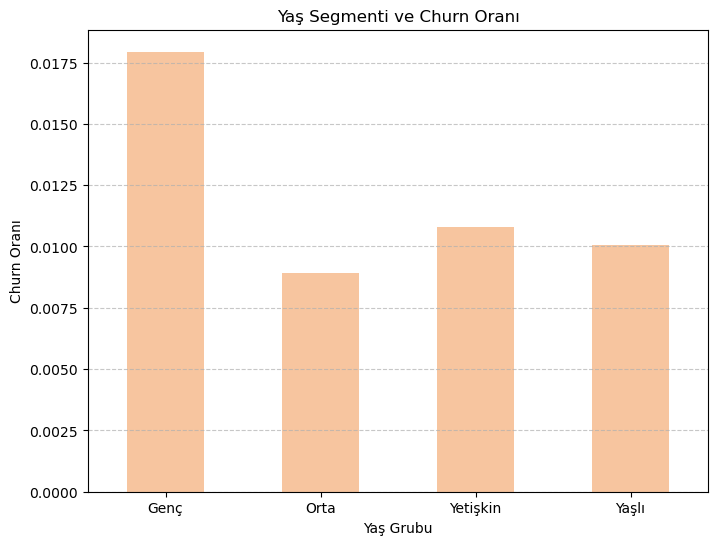

In [18]:

# 7️⃣ Yaş Segmenti ve Churn Oranı
plt.figure(figsize=(8, 6))
test_df.groupby("age_group")["churn"].mean().plot(kind="bar", color=colors[2])
plt.title("Yaş Segmenti ve Churn Oranı")
plt.xlabel("Yaş Grubu")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

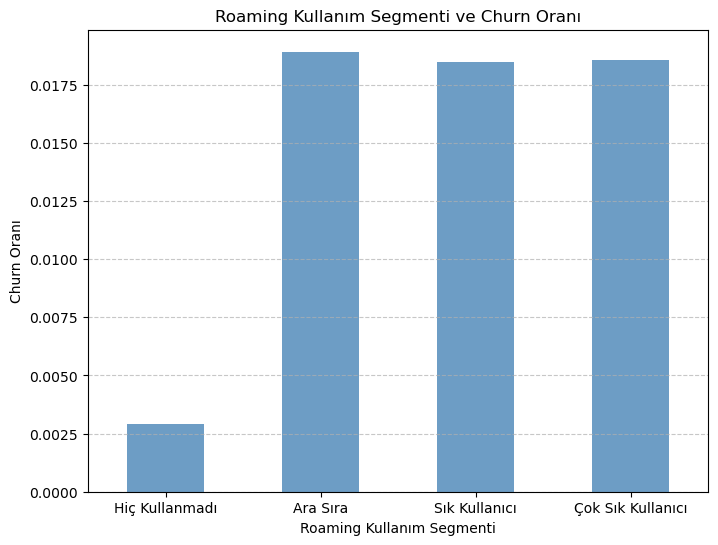

In [19]:

# 8️⃣ Roaming Kullanım Segmenti ve Churn Oranı
plt.figure(figsize=(8, 6))
test_df.groupby("roaming_usage_category")["churn"].mean().plot(kind="bar", color=colors[3])
plt.title("Roaming Kullanım Segmenti ve Churn Oranı")
plt.xlabel("Roaming Kullanım Segmenti")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

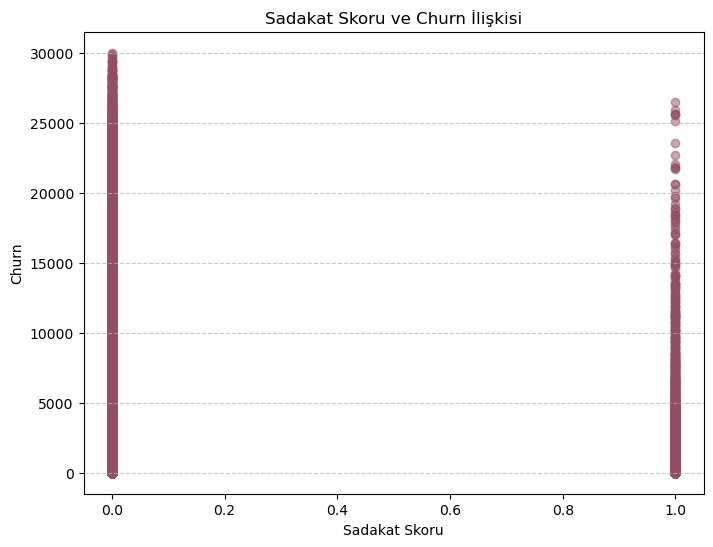

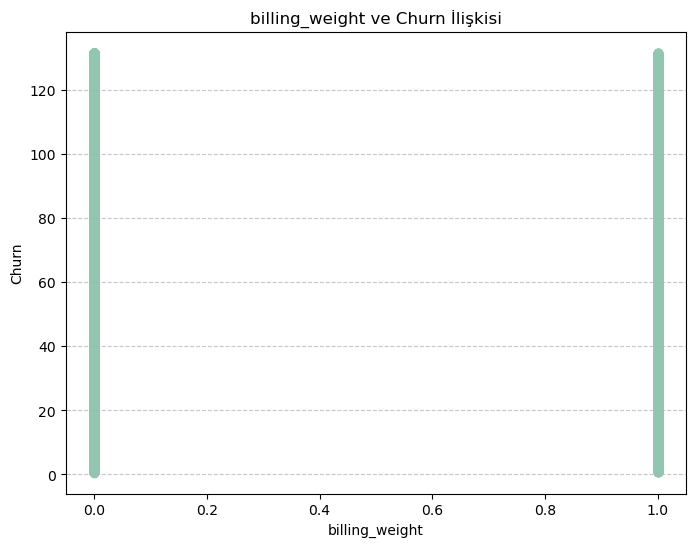

In [20]:

# 9️⃣ Sadakat Skoru ve Churn İlişkisi
plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"], test_df["loyalty_score"], alpha=0.5, color=colors[4])
plt.title("Sadakat Skoru ve Churn İlişkisi")
plt.xlabel("Sadakat Skoru")
plt.ylabel("Churn")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 🔟 Fatura Ağırlığı ve Churn İlişkisi
plt.figure(figsize=(8, 6))
plt.scatter(test_df["churn"], test_df["billing_weight"], alpha=0.5, color=colors[5])
plt.title("billing_weight ve Churn İlişkisi")
plt.xlabel("billing_weight")
plt.ylabel("Churn")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

sadakat skoru düşük olan müşteriler churn etmeye daha yatkın.

Yaşı küçük olup yüksek fatura ödeyen müşteriler churn etmeye daha yatkın.
Yaşına göre dengeli bir fatura ödeyen müşteriler daha sadık görünüyor.


Veri kullanımı (data_usage) ile churn arasında bir patlama noktası var mı?

Çok düşük veya çok yüksek veri kullananlar churn ediyor olabilir mi?

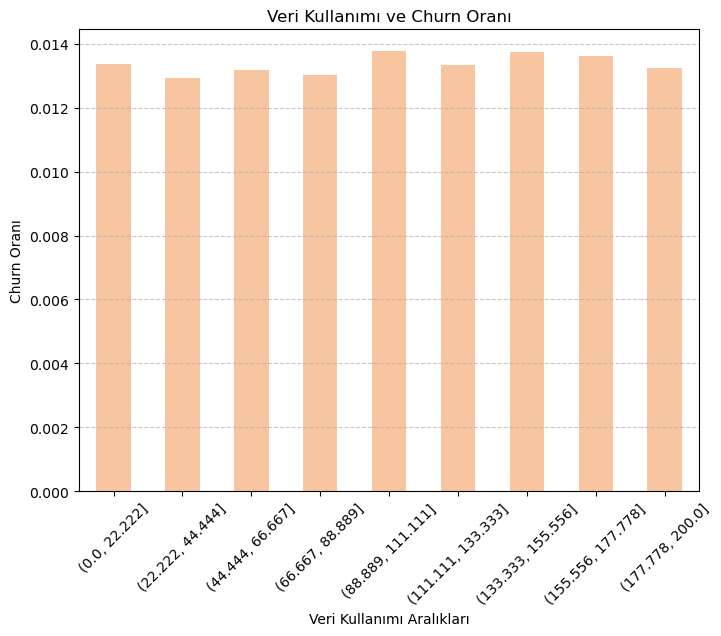

In [22]:
# 3️⃣ Veri Kullanımı ve Churn İlişkisi
plt.figure(figsize=(8, 6))
test_df.groupby(pd.cut(test_df["data_usage"], bins=np.linspace(0, test_df["data_usage"].max(), 10)))["churn"].mean().plot(kind="bar", color=colors[2])
plt.title("Veri Kullanımı ve Churn Oranı")
plt.xlabel("Veri Kullanımı Aralıkları")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
# 2️⃣ Memnuniyet Skoru ve Churn Eşik Noktası
plt.figure(figsize=(8, 6))
test_df.groupby(pd.cut(dtest_dff["satisfaction_score"], bins=np.linspace(0, test_df["satisfaction_score"].max(), 10)))["churn"].mean().plot(kind="bar", color=colors[1])
plt.title("Memnuniyet Skoru ve Churn Oranı")
plt.xlabel("Memnuniyet Skoru Aralıkları")
plt.ylabel("Churn Oranı")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()